# CHAPTER 5.2

### Creating a convolutional autoencoder

In this section , we'll implement a convolutional autoencoder to reproduce images from Fashion-MNIST.
we'll use reverse or transposed convolutions, which upscale volumes instead of downscaling them. This is what happens
in traditional convolutional layers.

In [1]:
import cv2
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import *

In [2]:
#load dataset, normalize and add channel dim
(X_train, _), (X_test, _) = fashion_mnist.load_data()

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [3]:
X_train.shape

(60000, 28, 28, 1)

In [4]:
X_test.shape

(10000, 28, 28, 1)

In [5]:
def build_autoencoder(input_shape=(28, 28, 1),
                      encoding_size=32,
                      alpha=0.2):
    # Build encoder first.
    inputs = Input(shape=input_shape)
    encoder = Conv2D(filters=32,
                     kernel_size=(3, 3),
                     strides=2,
                     padding='same')(inputs)
    encoder = LeakyReLU(alpha=alpha)(encoder)
    encoder = BatchNormalization()(encoder)

    encoder = Conv2D(filters=64,
                     kernel_size=(3, 3),
                     strides=2,
                     padding='same')(encoder)
    encoder = LeakyReLU(alpha=alpha)(encoder)
    encoder = BatchNormalization()(encoder)

    encoder_output_shape = encoder.shape
    encoder = Flatten()(encoder)
    encoder_output = Dense(units=encoding_size)(encoder)

    encoder_model = Model(inputs, encoder_output)

    # Build decoder
    decoder_input = Input(shape=(encoding_size,))
    target_shape = tuple(encoder_output_shape[1:])
    decoder = Dense(np.prod(target_shape))(decoder_input)
    decoder = Reshape(target_shape)(decoder)

    decoder = Conv2DTranspose(filters=64,
                              kernel_size=(3, 3),
                              strides=2,
                              padding='same')(decoder)
    decoder = LeakyReLU(alpha=alpha)(decoder)
    decoder = BatchNormalization()(decoder)

    decoder = Conv2DTranspose(filters=32,
                              kernel_size=(3, 3),
                              strides=2,
                              padding='same')(decoder)
    decoder = LeakyReLU(alpha=alpha)(decoder)
    decoder = BatchNormalization()(decoder)

    decoder = Conv2DTranspose(filters=1,
                              kernel_size=(3, 3),
                              padding='same')(decoder)
    outputs = Activation('sigmoid')(decoder)

    decoder_model = Model(decoder_input, outputs)

    encoder_model_output = encoder_model(inputs)
    decoder_model_output = decoder_model(encoder_model_output)
    autoencoder_model = Model(inputs, decoder_model_output)

    return encoder_model, decoder_model, autoencoder_model

In [6]:
enc_model, dec_model, autoencoder = build_autoencoder(encoding_size=256)

In [7]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 model (Functional)          (None, 256)               822272    
                                                                 
 model_1 (Functional)        (None, 28, 28, 1)         862017    
                                                                 
Total params: 1,684,289
Trainable params: 1,683,905
Non-trainable params: 384
_________________________________________________________________


In [8]:
enc_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 32)        0         
                                                                 
 batch_normalization (BatchN  (None, 14, 14, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                             

In [9]:
dec_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256)]             0         
                                                                 
 dense_1 (Dense)             (None, 3136)              805952    
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_2 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                           

In [10]:
autoencoder.compile(optimizer='adam', loss='mse')

EPOCHS = 300
BATCH_SIZE = 1024
autoencoder.fit(X_train, X_train,
                epochs=EPOCHS,
                batch_size=BATCH_SIZE,
                shuffle=True,
                validation_data=(X_test, X_test),
                verbose=1)

Epoch 1/300
59/59 [==============================] - 14s 65ms/step - loss: 0.0422 - val_loss: 0.1129
Epoch 2/300
59/59 [==============================] - 3s 57ms/step - loss: 0.0143 - val_loss: 0.1111
Epoch 3/300
59/59 [==============================] - 3s 57ms/step - loss: 0.0090 - val_loss: 0.1020
Epoch 4/300
59/59 [==============================] - 3s 57ms/step - loss: 0.0070 - val_loss: 0.0886
Epoch 5/300
59/59 [==============================] - 3s 57ms/step - loss: 0.0058 - val_loss: 0.0681
Epoch 6/300
59/59 [==============================] - 3s 57ms/step - loss: 0.0050 - val_loss: 0.0454
Epoch 7/300
59/59 [==============================] - 3s 56ms/step - loss: 0.0045 - val_loss: 0.0269
Epoch 8/300
59/59 [==============================] - 3s 56ms/step - loss: 0.0041 - val_loss: 0.0144
Epoch 9/300
59/59 [==============================] - 3s 57ms/step - loss: 0.0038 - val_loss: 0.0074
Epoch 10/300
59/59 [==============================] - 3s 59ms/step - loss: 0.0036 - val_loss: 0.005

59/59 [==============================] - 3s 57ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 82/300
59/59 [==============================] - 3s 58ms/step - loss: 0.0014 - val_loss: 0.0016 0s - 
Epoch 83/300
59/59 [==============================] - 3s 58ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 84/300
59/59 [==============================] - 4s 60ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 85/300
59/59 [==============================] - 4s 61ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 86/300
59/59 [==============================] - 4s 61ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 87/300
59/59 [==============================] - 3s 58ms/step - loss: 0.0014 - val_loss: 0.0017
Epoch 88/300
59/59 [==============================] - 4s 61ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 89/300
59/59 [==============================] - 3s 58ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 90/300
59/59 [==============================] - 3s 57ms/step - loss: 0.0014 - val_loss: 0.00

59/59 [==============================] - 4s 60ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 162/300
59/59 [==============================] - 3s 59ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 163/300
59/59 [==============================] - 3s 59ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 164/300
59/59 [==============================] - 3s 59ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 165/300
59/59 [==============================] - 3s 59ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 166/300
59/59 [==============================] - 3s 59ms/step - loss: 0.0012 - val_loss: 0.0016: 0s -
Epoch 167/300
59/59 [==============================] - 3s 59ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 168/300
59/59 [==============================] - 3s 59ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 169/300
59/59 [==============================] - 3s 59ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 170/300
59/59 [==============================] - 3s 58ms/step - loss: 0.0011 - val_l

59/59 [==============================] - 3s 56ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 242/300
59/59 [==============================] - 3s 56ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 243/300
59/59 [==============================] - 3s 56ms/step - loss: 0.0010 - val_loss: 0.00149
Epoch 244/300
59/59 [==============================] - 3s 57ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 245/300
59/59 [==============================] - 3s 57ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 246/300
59/59 [==============================] - 3s 57ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 247/300
59/59 [==============================] - 3s 56ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 248/300
59/59 [==============================] - 3s 57ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 249/300
59/59 [==============================] - 3s 57ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 250/300
59/59 [==============================] - 3s 57ms/step - loss: 0.0010 - val_loss: 

In [11]:
predictions = autoencoder.predict(X_test)

In [12]:
predictions.shape

(10000, 28, 28, 1)

In [13]:
original_shape = (X_test.shape[0], 28, 28)
predictions = predictions.reshape(original_shape)
X_test = X_test.reshape(original_shape)

predictions = (predictions * 255.0).astype('uint8')
X_test = (X_test * 255.0).astype('uint8')

In [14]:
def plot_original_vs_generated(original, generated):
    num_images = 15
    sample = np.random.randint(0, len(original), num_images)

    def stack(data):
        images = data[sample]
        return np.vstack([np.hstack(images[:5]),
                          np.hstack(images[5:10]),
                          np.hstack(images[10:15])])

    def add_text(image, text, position):
        pt1 = position
        pt2 = (pt1[0] + 10 + (len(text) * 22),
               pt1[1] - 45)
        cv2.rectangle(image,
                      pt1,
                      pt2,
                      (255, 255, 255),
                      -1)
        cv2.putText(image, text,
                    position,
                    fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=1.3,
                    color=(0, 0, 0),
                    thickness=4)

    original = stack(original)
    generated = stack(generated)

    mosaic = np.vstack([original,
                        generated])
    mosaic = cv2.resize(mosaic, (800, 800),
                        interpolation=cv2.INTER_AREA)
    mosaic = cv2.cvtColor(mosaic, cv2.COLOR_GRAY2BGR)

    add_text(mosaic, 'Original', (20, 80))
    add_text(mosaic, 'Generated', (20, 500))

    cv2.imshow('Mosaic_of_ConAutoencoder', mosaic)
    cv2.waitKey(0)

In [15]:
plot_original_vs_generated(X_test, predictions)

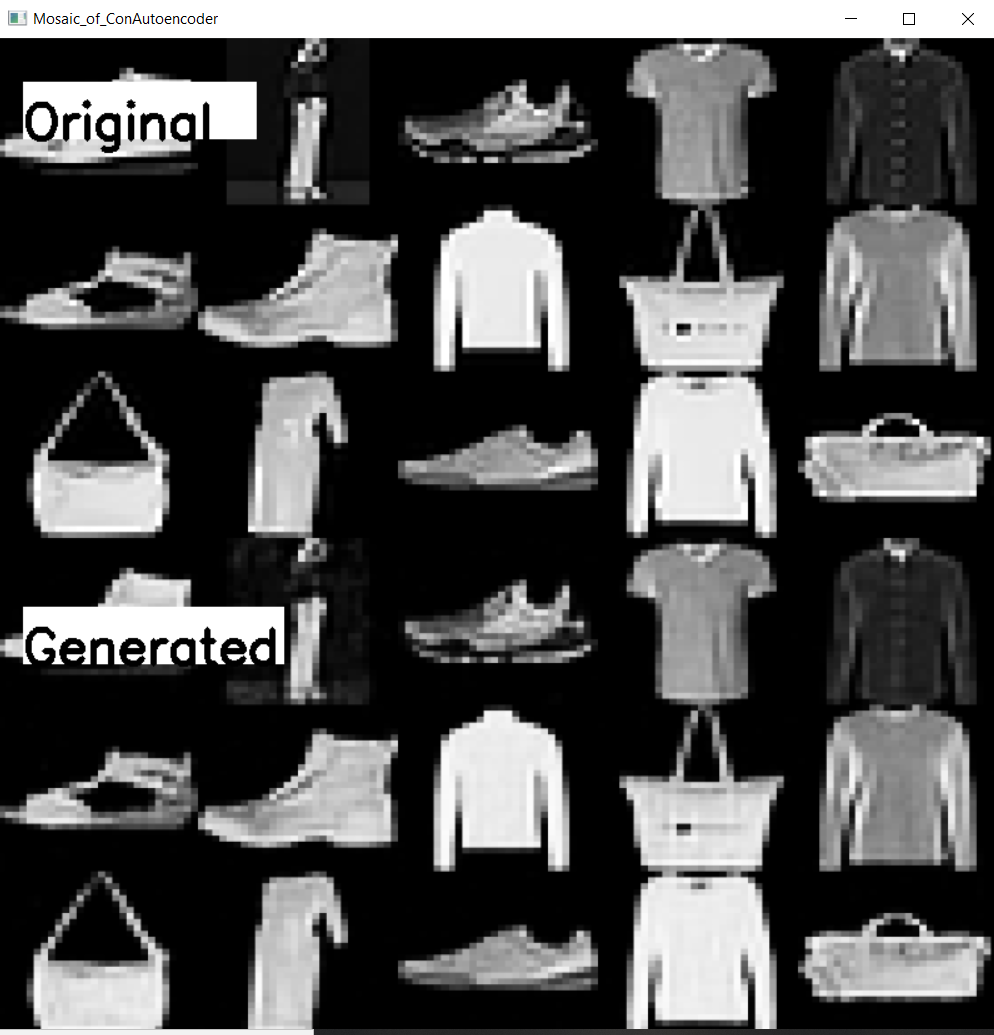

## !!! In an autoencoder, the size of the encoding is crucial to guarantee the decoderhas enough information to reconstruct the input.!!!